In [1]:
import sys
import os
os.chdir(r'..')
sys.path.append(os.getcwd() + '/outputs')
sys.path.append(os.getcwd() + '/functions')
sys.path.append(os.getcwd() + '/data')

import pandas as pd
import numpy as np
import make_network as mn
import networkx as nx
import scipy.stats as st

from patsy import dmatrices

import matplotlib.pyplot as plt

import matplotlib
import seaborn as sbn 

import network_analysis as nal

import igraph as ig

import transnet


%matplotlib inline

/Users/jmunday/Documents/Measles_NL


## Data import

Importing the school data including the unique identifier (BRIN), denomination of the school (denominatie), coordinates, postcode, procivnce, and population (total and by school year) 

In [2]:
vo_frame = pd.read_csv('data/Location data/vo_jan2013.csv', encoding='iso-8859-1')
bo_frame = pd.read_csv('data/Location data/bo_jan2013.csv', encoding='iso-8859-1')
so_frame = pd.read_csv('data/Location data/so_jan2013.csv', encoding='iso-8859-1')

In [3]:
all_frame = pd.concat([vo_frame, bo_frame, so_frame])

## Schools in the Netherlands

Breakdown of schools by denomination

In [4]:
school_count = transnet.school_data.groupby('Denomination').count()[['BRIN']].sort_values('BRIN', ascending=False).reset_index().rename(columns = {'BRIN':'Schools'})
school_count['mix'] = ['Samen' not in n for n in school_count.Denomination]
pri_count = transnet.school_data.query('kind=="pri"').groupby('Denomination').count()[['BRIN']].sort_values('BRIN', ascending=False).reset_index().rename(columns = {'BRIN':'Primary'})
sec_count = transnet.school_data.query('kind=="sec"').groupby('Denomination').count()[['BRIN']].sort_values('BRIN', ascending=False).reset_index().rename(columns = {'BRIN':'Secondary'})

school_count = school_count.merge(pri_count, on='Denomination', how='outer' )
school_count = school_count.merge(sec_count, on='Denomination', how='outer' )

school_count = school_count.sort_values(['mix', 'Schools'], ascending=False).fillna(0).drop('mix', axis=1)
school_count



,Denomination,Schools,Primary,Secondary
0,Openbaar,2810,2466.0,344.0
1,Rooms-Katholiek,2554,2258.0,296.0
2,Protestants-Christelijk,2147,1904.0,243.0
3,Algemeen bijzonder,807,579.0,228.0
4,Reformatorisch,208,181.0,27.0
6,Gereformeerd vrijgemaakt,118,118.0,0.0
7,Antroposofisch,81,70.0,11.0
8,Islamitisch,44,43.0,1.0
10,Interconfessioneel,21,15.0,6.0
11,Gereformeerd,18,0.0,18.0


Proportion of children and schools of each denomination 

In [6]:
prop_students_by_den = all_frame.groupby('denominatie').sum().leerlingen/all_frame.leerlingen.sum()

In [7]:
prop_schools_by_den = all_frame.groupby('denominatie').count().objectid/len(all_frame)

In [8]:
percent_rep_tab = 100*pd.DataFrame([prop_schools_by_den,
                                    prop_students_by_den]).transpose().rename(columns={'objectid':'schools', 
                                                                                       'leerlingen':'Pupils'}).sort_values('schools', 
                                                                                                                           ascending=False)
percent_rep_tab = percent_rep_tab.reset_index()
percent_rep_tab['mix'] = ['Samen' not in n for n in percent_rep_tab.denominatie]


Text(0.5, 0, '%')

/Users/jmunday/miniconda3/envs/Measles_NL/lib/python3.9/site-packages/IPython/core/events.py:93: UserWarning: Glyph 149 (\x95) missing from current font.
  func(*args, **kwargs)
/Users/jmunday/miniconda3/envs/Measles_NL/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 149 (\x95) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


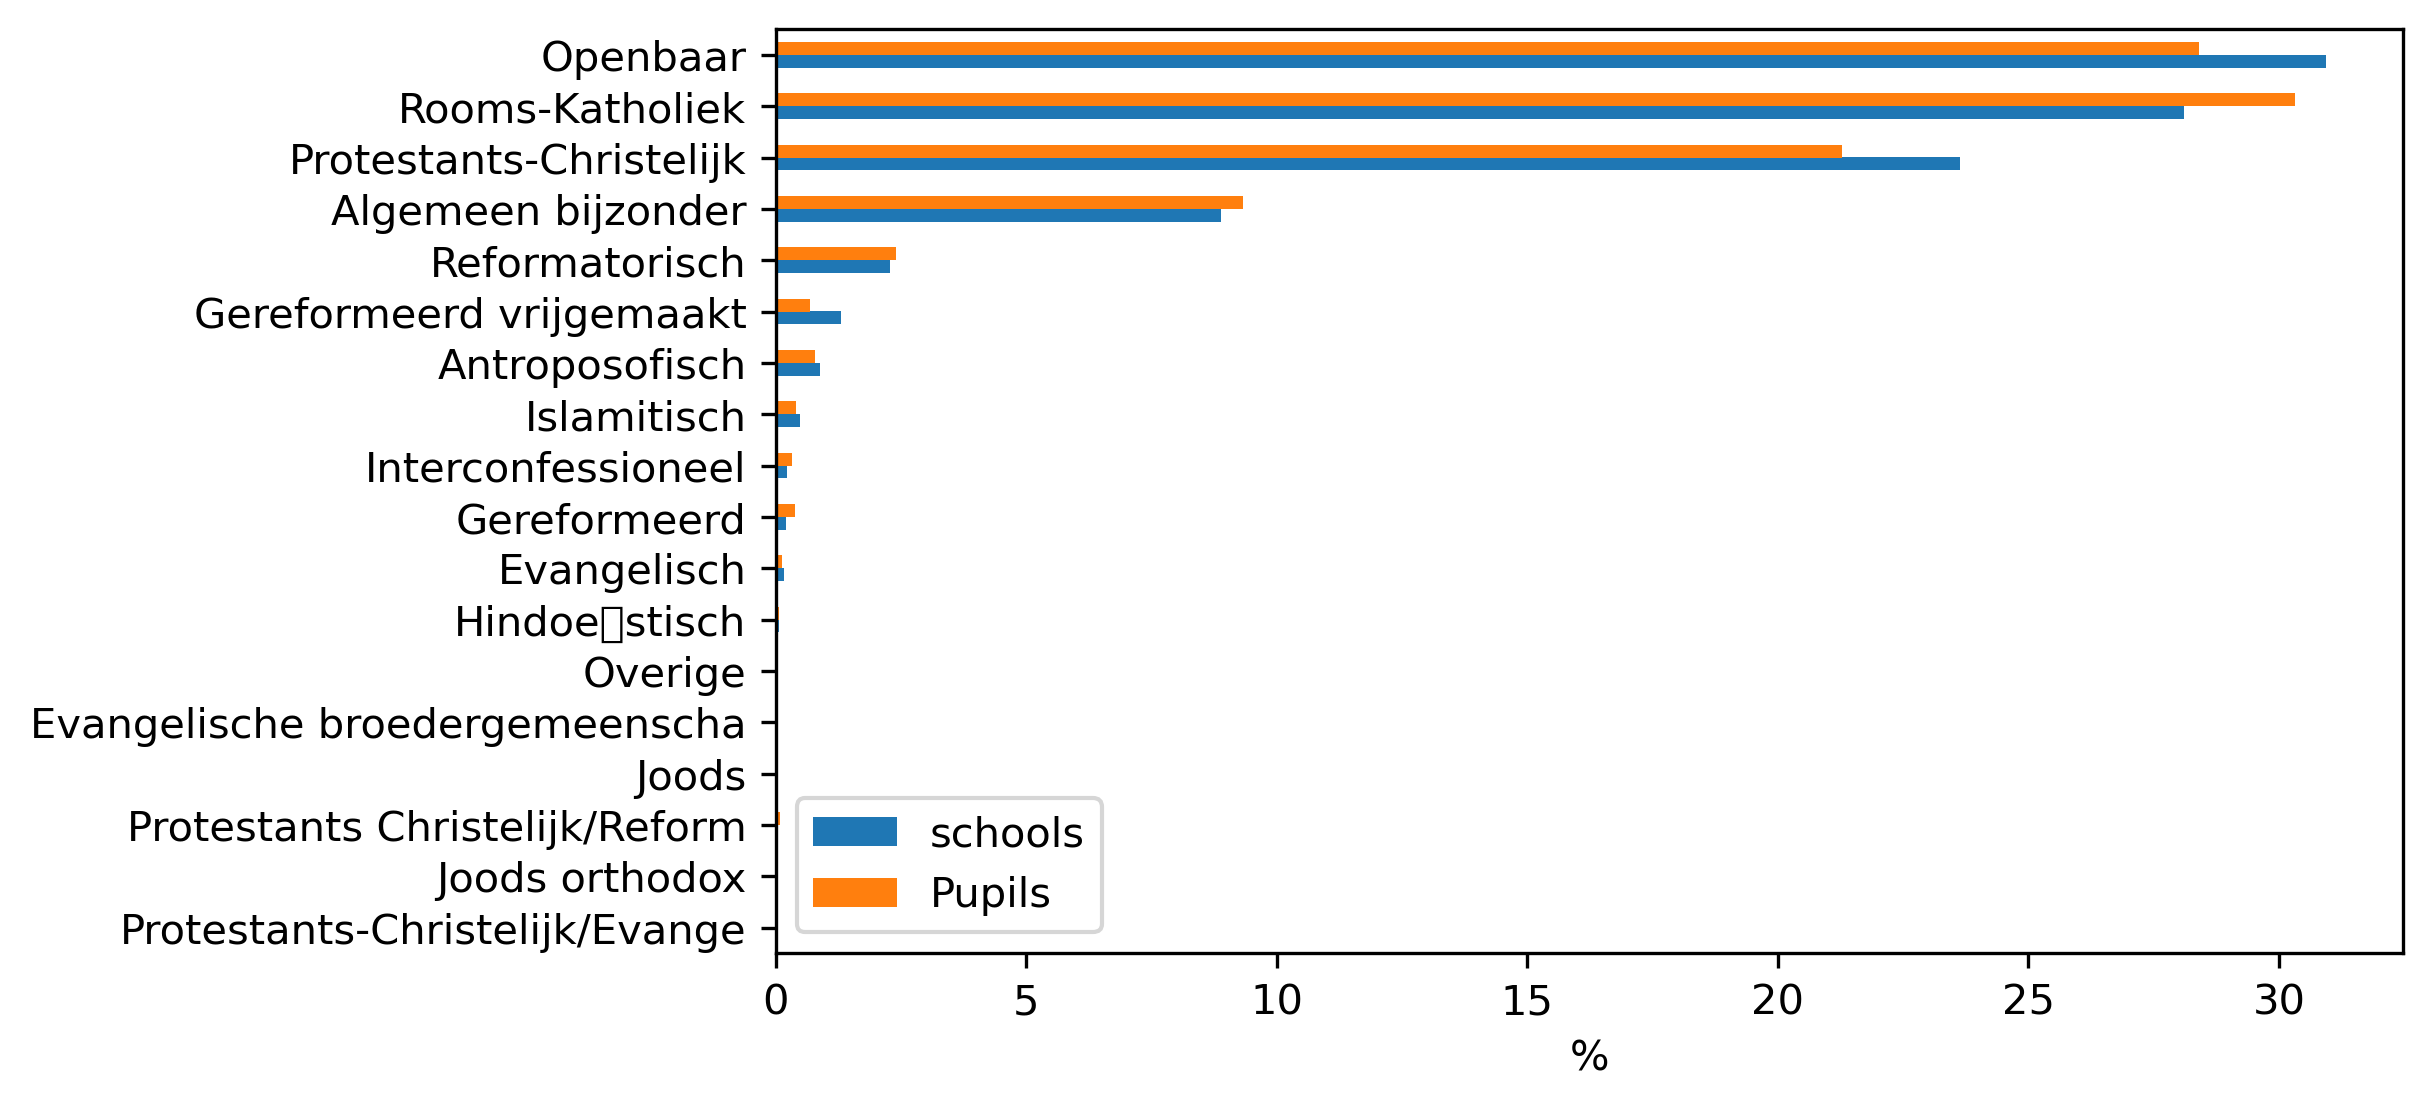

In [9]:
fig =plt.figure(figsize=[7,4], dpi=300)
ax=fig.add_subplot(111)
percent_rep_tab.sort_values(['mix', 'schools'], ascending=True).fillna(0).query('mix != 0').drop('mix', axis=1).set_index('denominatie').plot(kind='barh', ax=ax)
ax.set_ylabel('')
ax.set_xlabel('%')


## Characteristics of the schools in the network

In [10]:
degree_df = pd.DataFrame.from_dict(dict(transnet.data_net.degree()), orient='index', columns=['degree']).reset_index().rename(columns={'index':'BRIN'})
weighted_degree_df = pd.DataFrame.from_dict(dict(transnet.data_net.degree(weight='weight')), orient='index', columns=['weighted_degree']).reset_index().rename(columns={'index':'BRIN'})

In [11]:
all_frame = all_frame.rename(columns={u'vestigingsnummer':'BRIN'})

In [12]:
all_frame = all_frame.merge(weighted_degree_df, on='BRIN')
all_frame = all_frame.merge(degree_df, on='BRIN')

### Weighted degree vs degree distributions for the whole network 

Degree and weighted degree distributions of the network

<Axes: ylabel='Frequency'>

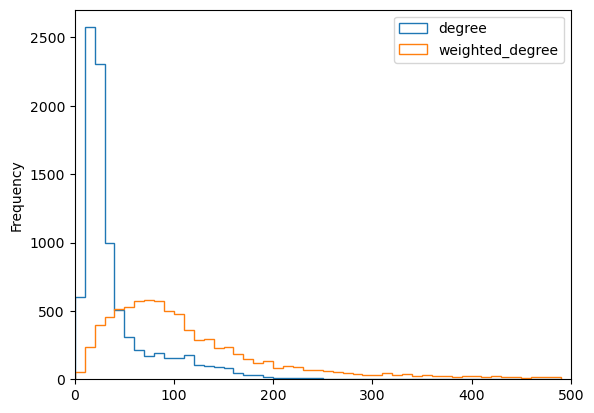

In [13]:
all_frame.plot(y=['degree', 'weighted_degree'], kind='hist',bins=range(0,500,10), xlim=[0,500], histtype='step', alpha=1.)

Degree vs weighted degree for the whole network and key denominations 

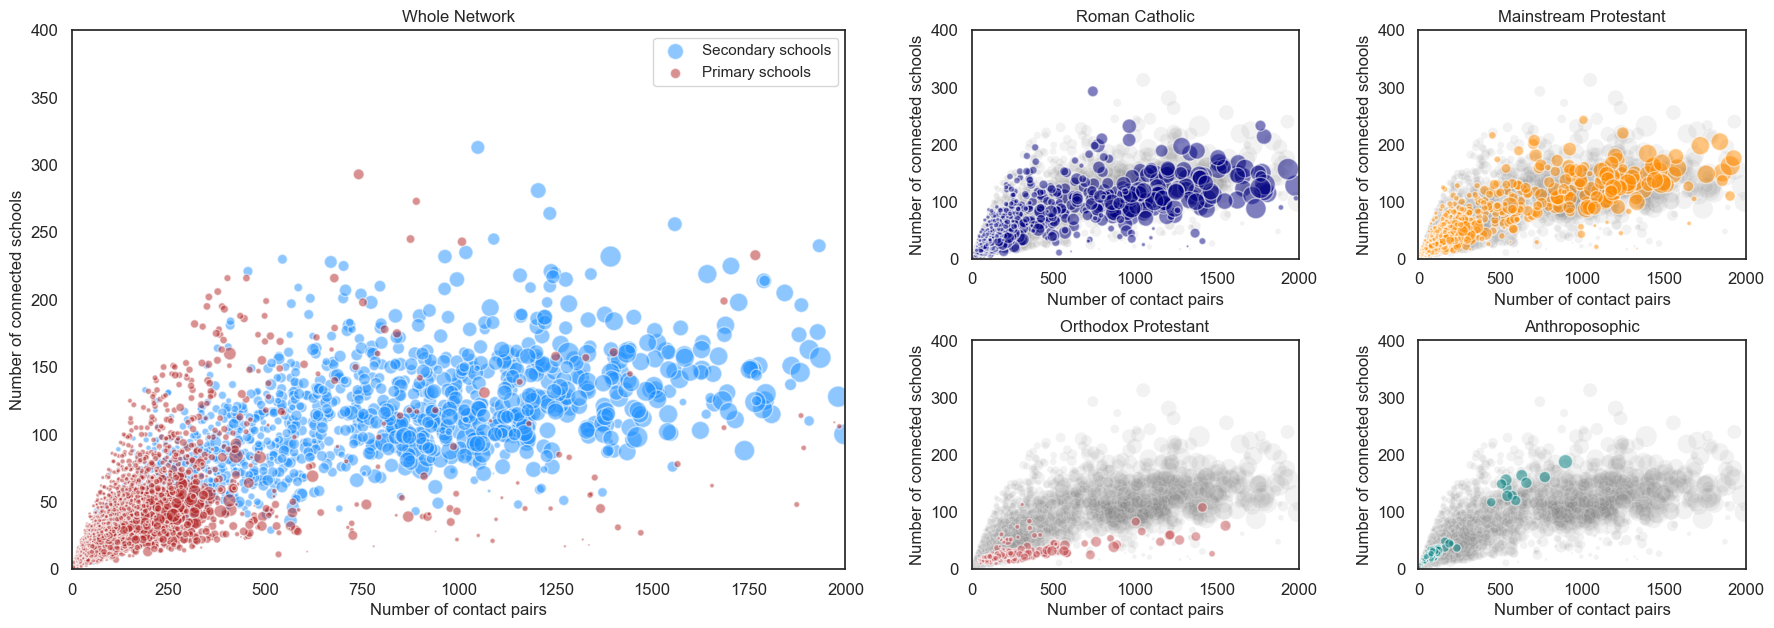

In [32]:
max_w = 2000.
max_d = 400.
sbn.set(style="white", color_codes=True)

font = {'size'   : 100}

matplotlib.rc('font', **font)

titles =['Whole Network', 'Roman Catholic', 'Mainstream Protestant', 'Orthodox Protestant', 'Anthroposophic']

from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=[18,7])


gs1 = GridSpec(3, 3)
gs1.update(left=0.05, right=0.48, wspace=0.05)
ax1 = plt.subplot(gs1[:, :])


gs2 = GridSpec(40, 40)
gs2.update(left=0.55, right=0.98, hspace=0.05)
ax2 = plt.subplot(gs2[:-23, :-23])
ax3 = plt.subplot(gs2[:-23, -17:])
ax4 = plt.subplot(gs2[-17:, :-23])
ax5 = plt.subplot(gs2[-17:, -17:])



plot_data = all_frame.query('degree <= @max_d and weighted_degree<=@max_w and BRIN in @sec_codes')
plot_data.plot(y='degree', x='weighted_degree', kind='scatter', ylim=[0,max_d], xlim=[0,max_w], s=plot_data.leerlingen*0.1, edgecolor="w", linewidth=1, alpha=0.5, color='DodgerBlue', ax=ax1, fontsize=12, label='Secondary schools')
plot_data = all_frame.query('degree <= @max_d and weighted_degree<=@max_w and BRIN not in @sec_codes')
plot_data.plot(y='degree', x='weighted_degree', kind='scatter', ylim=[0,max_d], xlim=[0,max_w], s=plot_data.leerlingen*0.1, edgecolor="w", linewidth=1, alpha=0.5, color='FireBrick', ax=ax1, fontsize=12, label='Primary schools')


plot_data = all_frame.query('denominatie != "Rooms-Katholiek"').query('degree <= @max_d and weighted_degree<=@max_w')
plot_data.plot( y='degree', x='weighted_degree', kind='scatter', ylim=[0,max_d], xlim=[0,max_w], s=plot_data.leerlingen*0.1, edgecolor="w", linewidth=1, alpha=0.1, color='Grey',  ax=ax2, fontsize=12)
plot_data = all_frame.query('denominatie == "Rooms-Katholiek"').query('degree <= @max_d and weighted_degree<=@max_w')
plot_data.plot( y='degree', x='weighted_degree', kind='scatter', ylim=[0,max_d], xlim=[0,max_w], s=plot_data.leerlingen*0.1, edgecolor="w", linewidth=1, alpha=0.5, color='Navy',  ax=ax2, fontsize=12)

plot_data = all_frame.query('denominatie != "Protestants-Christelijk"').query('degree <= @max_d and weighted_degree<=@max_w')
plot_data.plot( y='degree', x='weighted_degree', kind='scatter', ylim=[0,max_d], xlim=[0,max_w], s=plot_data.leerlingen*0.1, edgecolor="w", linewidth=1, alpha=0.1, color='Grey',  ax=ax3, fontsize=12)
plot_data = all_frame.query('denominatie == "Protestants-Christelijk"').query('degree <= @max_d and weighted_degree<=@max_w')
plot_data.plot( y='degree', x='weighted_degree', kind='scatter', ylim=[0,max_d], xlim=[0,max_w], s=plot_data.leerlingen*0.1, edgecolor="w", linewidth=1, alpha=0.5, color='DarkOrange',  ax=ax3, fontsize=12)


plot_data = all_frame.query('denominatie != "Reformatorisch"').query('degree <= @max_d and weighted_degree<=@max_w')
plot_data.plot( y='degree', x='weighted_degree', kind='scatter', ylim=[0,max_d], xlim=[0,max_w], s=plot_data.leerlingen*0.1, edgecolor="w", linewidth=1, alpha=0.1, color='Grey',  ax=ax4, fontsize=12)
plot_data = all_frame.query('denominatie == "Reformatorisch"').query('degree <= @max_d and weighted_degree<=@max_w')
plot_data.plot(y='degree', x='weighted_degree', kind='scatter', ylim=[0,max_d], xlim=[0,max_w], s=plot_data.leerlingen*0.1, edgecolor="w", linewidth=1, alpha=0.5, color='r',  ax=ax4, fontsize=12)



plot_data = all_frame.query('denominatie != "Antroposofisch"').query('degree <= @max_d and weighted_degree<=@max_w')
plot_data.plot( y='degree', x='weighted_degree', kind='scatter', ylim=[0,max_d], xlim=[0,max_w], s=plot_data.leerlingen*0.1, edgecolor="w", linewidth=1, alpha=0.1, color='Grey',  ax=ax5, fontsize=12)
plot_data = all_frame.query('denominatie == "Antroposofisch"').query('degree <= @max_d and weighted_degree<=@max_w')
plot_data.plot(y='degree', x='weighted_degree', kind='scatter', ylim=[0,max_d], xlim=[0,max_w], s=plot_data.leerlingen*0.1, edgecolor="w", linewidth=1, alpha=0.5, color='Teal',  ax=ax5, fontsize=12)

for i, ax in enumerate([ax1, ax2, ax3, ax4, ax5]):
    ax.set_xlabel('Number of contact pairs', fontsize='12')
    ax.set_ylabel('Number of connected schools', fontsize='12')
    ax.set_title(titles[i], fontsize='12')
plt.savefig('plots/degree_fig.png', dpi=300) 
plt.savefig('plots/degree_fig.pdf') 

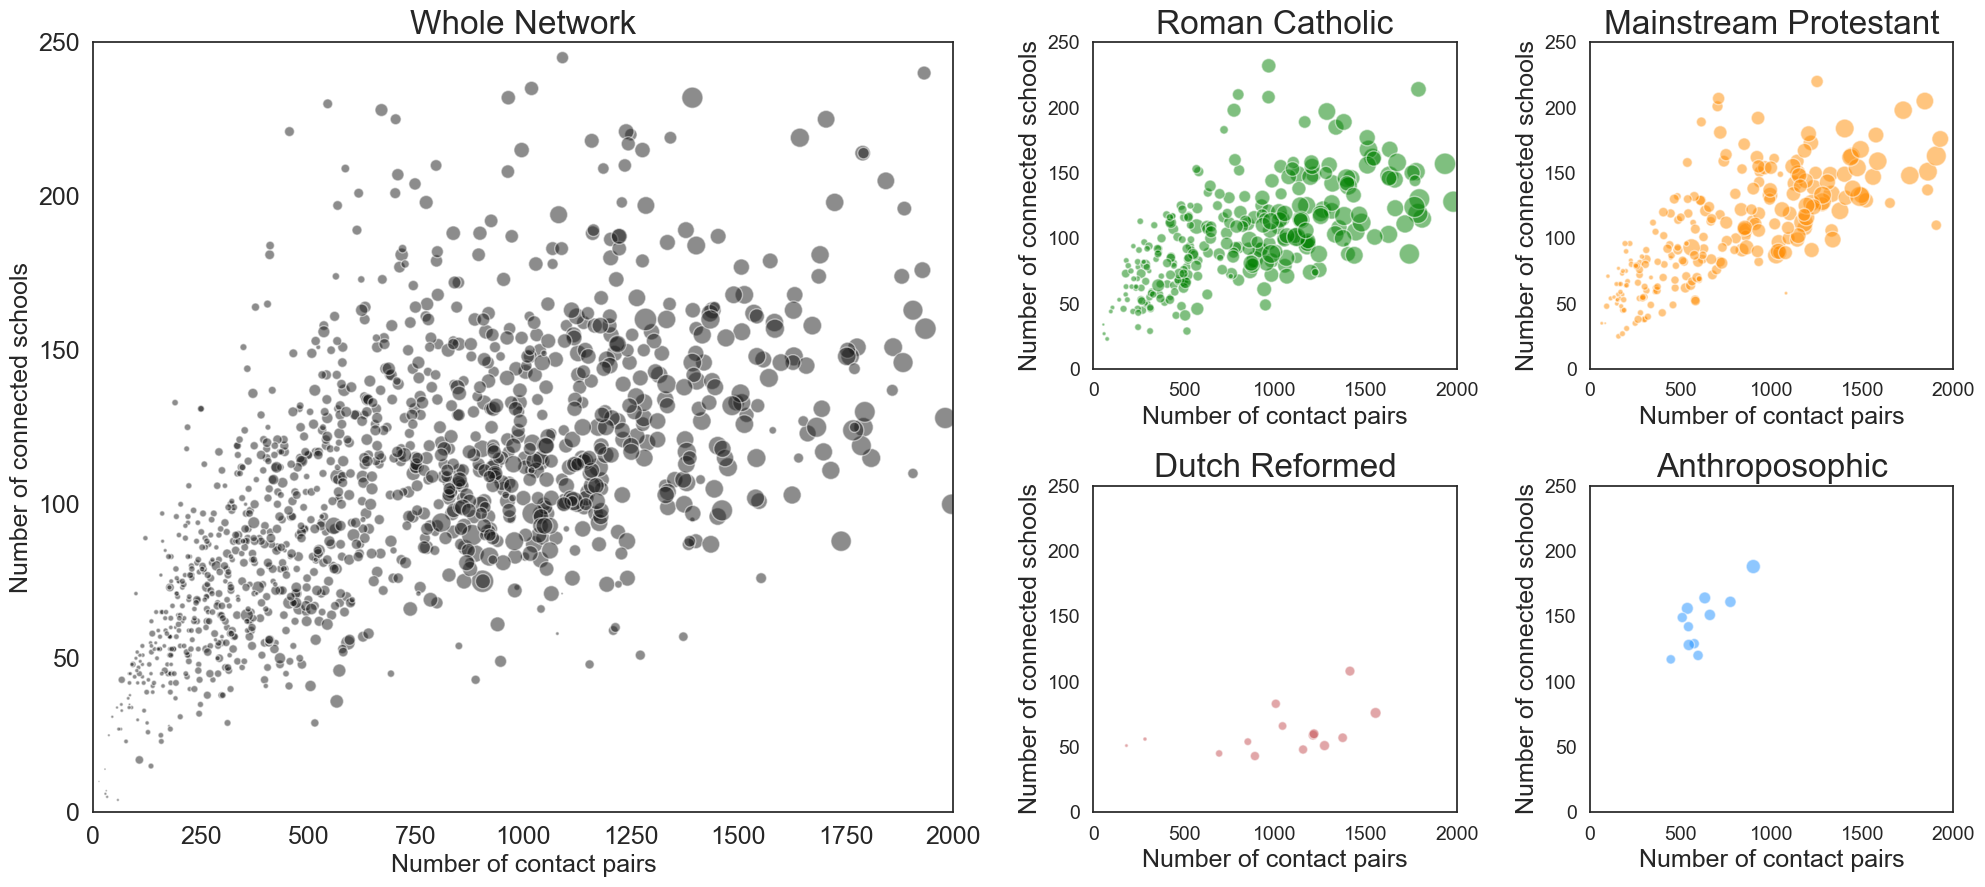

In [15]:

sec_codes = vo_frame.vestigingsnummer

max_w = 2000.
sbn.set(style="white", color_codes=True)

font = {'size'   : 100}

matplotlib.rc('font', **font)

titles =['Whole Network', 'Roman Catholic', 'Mainstream Protestant', 'Dutch Reformed', 'Anthroposophic']

from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=[20,10])


gs1 = GridSpec(3, 3)
gs1.update(left=0.05, right=0.48, wspace=0.05)
ax1 = plt.subplot(gs1[:, :])


gs2 = GridSpec(40, 40)
gs2.update(left=0.55, right=0.98, hspace=0.05)
ax2 = plt.subplot(gs2[:-23, :-23])
ax3 = plt.subplot(gs2[:-23, -17:])
ax4 = plt.subplot(gs2[-17:, :-23])
ax5 = plt.subplot(gs2[-17:, -17:])



plot_data = all_frame.query('degree <= 250 and weighted_degree<=@max_w and BRIN in @sec_codes')
plot_data.plot(y='degree', x='weighted_degree', kind='scatter', ylim=[0,250], xlim=[0,max_w], s=plot_data.leerlingen*0.1, edgecolor="w", linewidth=1, alpha=0.5, color='k', ax=ax1, fontsize=18)

plot_data = all_frame.query('denominatie == "Rooms-Katholiek" and BRIN in @sec_codes').query('degree <= 250 and weighted_degree<=@max_w')
plot_data.plot( y='degree', x='weighted_degree', kind='scatter', ylim=[0,250], xlim=[0,max_w], s=plot_data.leerlingen*0.1, edgecolor="w", linewidth=1, alpha=0.5, color='Green',  ax=ax2, fontsize=14)
plot_data = all_frame.query('denominatie == "Protestants-Christelijk" and BRIN in @sec_codes').query('degree <= 250 and weighted_degree<=@max_w')
plot_data.plot( y='degree', x='weighted_degree', kind='scatter', ylim=[0,250], xlim=[0,max_w], s=plot_data.leerlingen*0.1, edgecolor="w", linewidth=1, alpha=0.5, color='DarkOrange',  ax=ax3, fontsize=14)


plot_data = all_frame.query('denominatie == "Reformatorisch" and BRIN in @sec_codes').query('degree <= 250 and weighted_degree<=@max_w')
plot_data.plot(y='degree', x='weighted_degree', kind='scatter', ylim=[0,250], xlim=[0,max_w], s=plot_data.leerlingen*0.1, edgecolor="w", linewidth=1, alpha=0.5, color='r',  ax=ax4, fontsize=14)
plot_data = all_frame.query('denominatie == "Antroposofisch" and BRIN in @sec_codes').query('degree <= 250 and weighted_degree<=@max_w')
plot_data.plot(y='degree', x='weighted_degree', kind='scatter', ylim=[0,250], xlim=[0,max_w], s=plot_data.leerlingen*0.1, edgecolor="w", linewidth=1, alpha=0.5, color='DodgerBlue',  ax=ax5, fontsize=14)

for i, ax in enumerate([ax1, ax2, ax3, ax4, ax5]):
    ax.set_xlabel('Number of contact pairs', fontsize='18')
    ax.set_ylabel('Number of connected schools', fontsize='18')
    ax.set_title(titles[i], fontsize='24')

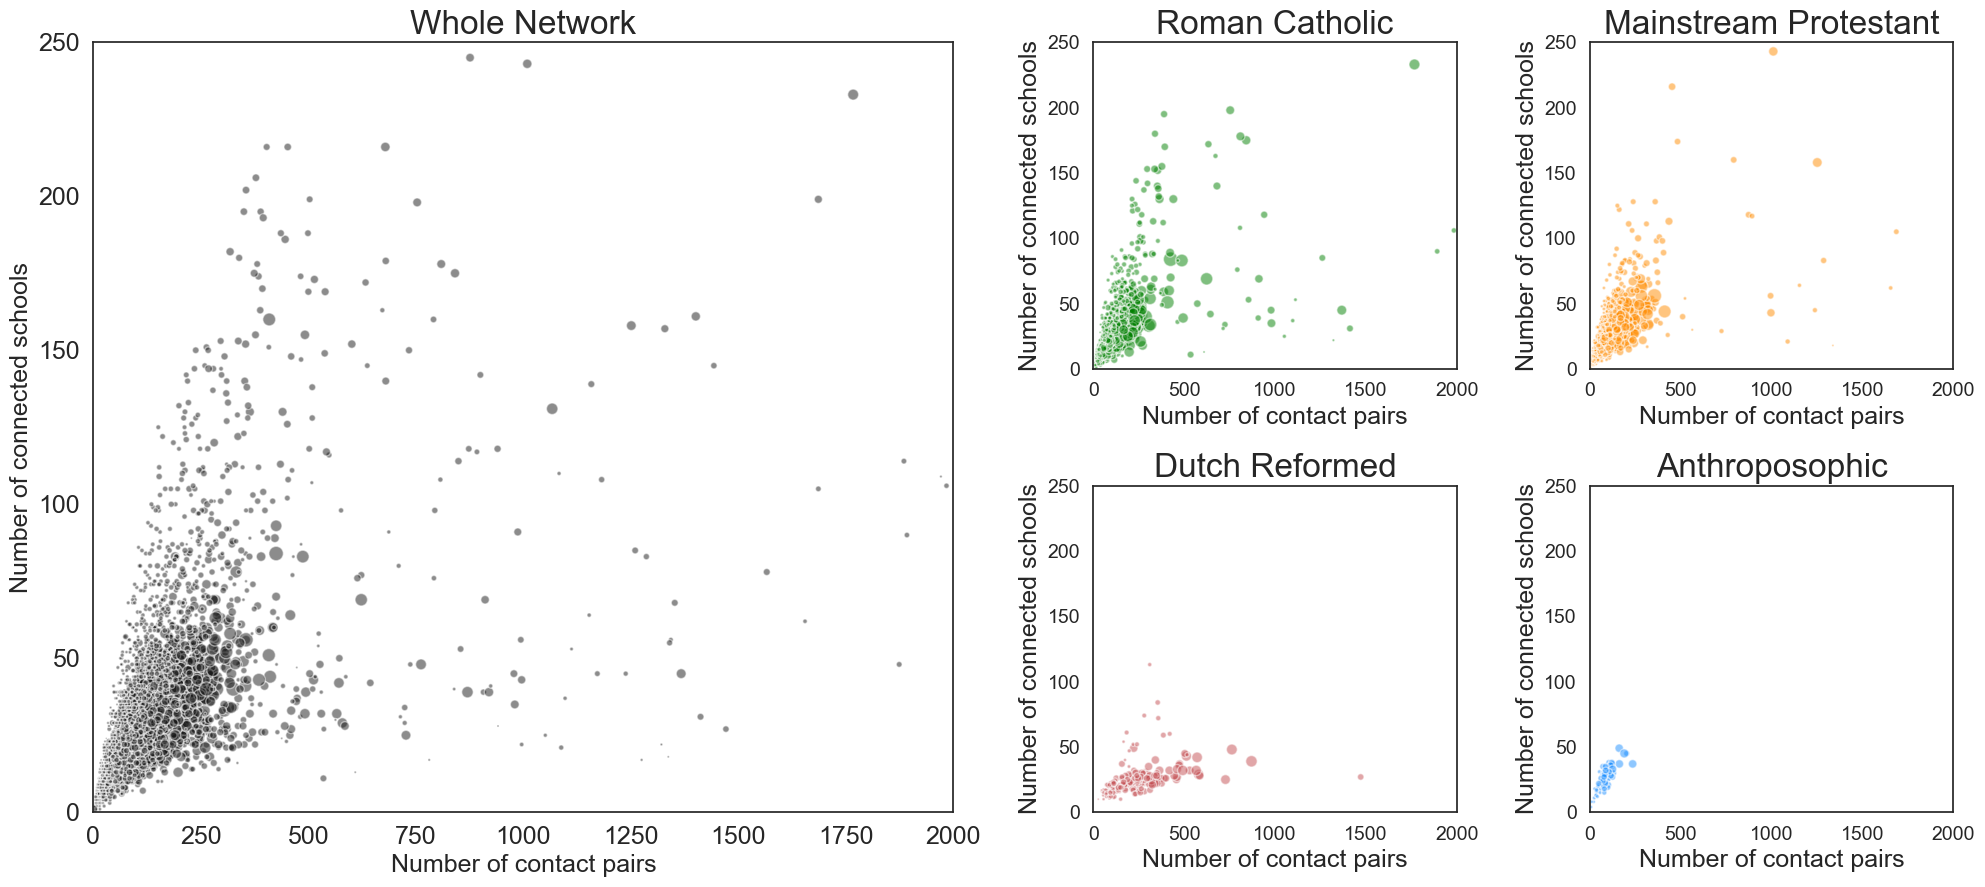

In [16]:
max_w = 2000.
sbn.set(style="white", color_codes=True)

font = {'size'   : 100}

matplotlib.rc('font', **font)

titles =['Whole Network', 'Roman Catholic', 'Mainstream Protestant', 'Dutch Reformed', 'Anthroposophic']

from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=[20,10])


gs1 = GridSpec(3, 3)
gs1.update(left=0.05, right=0.48, wspace=0.05)
ax1 = plt.subplot(gs1[:, :])


gs2 = GridSpec(40, 40)
gs2.update(left=0.55, right=0.98, hspace=0.05)
ax2 = plt.subplot(gs2[:-23, :-23])
ax3 = plt.subplot(gs2[:-23, -17:])
ax4 = plt.subplot(gs2[-17:, :-23])
ax5 = plt.subplot(gs2[-17:, -17:])



plot_data = all_frame.query('degree <= 250 and weighted_degree<=@max_w and BRIN not in @sec_codes')
plot_data.plot(y='degree', x='weighted_degree', kind='scatter', ylim=[0,250], xlim=[0,max_w], s=plot_data.leerlingen*0.1, edgecolor="w", linewidth=1, alpha=0.5, color='k', ax=ax1, fontsize=18)

plot_data = all_frame.query('denominatie == "Rooms-Katholiek" and BRIN not in @sec_codes').query('degree <= 250 and weighted_degree<=@max_w')
plot_data.plot( y='degree', x='weighted_degree', kind='scatter', ylim=[0,250], xlim=[0,max_w], s=plot_data.leerlingen*0.1, edgecolor="w", linewidth=1, alpha=0.5, color='Green',  ax=ax2, fontsize=14)
plot_data = all_frame.query('denominatie == "Protestants-Christelijk" and BRIN not in @sec_codes').query('degree <= 250 and weighted_degree<=@max_w')
plot_data.plot( y='degree', x='weighted_degree', kind='scatter', ylim=[0,250], xlim=[0,max_w], s=plot_data.leerlingen*0.1, edgecolor="w", linewidth=1, alpha=0.5, color='DarkOrange',  ax=ax3, fontsize=14)


plot_data = all_frame.query('denominatie == "Reformatorisch" and BRIN not in @sec_codes').query('degree <= 250 and weighted_degree<=@max_w')
plot_data.plot(y='degree', x='weighted_degree', kind='scatter', ylim=[0,250], xlim=[0,max_w], s=plot_data.leerlingen*0.1, edgecolor="w", linewidth=1, alpha=0.5, color='r',  ax=ax4, fontsize=14)
plot_data = all_frame.query('denominatie == "Antroposofisch" and BRIN not in @sec_codes').query('degree <= 250 and weighted_degree<=@max_w')
plot_data.plot(y='degree', x='weighted_degree', kind='scatter', ylim=[0,250], xlim=[0,max_w], s=plot_data.leerlingen*0.1, edgecolor="w", linewidth=1, alpha=0.5, color='DodgerBlue',  ax=ax5, fontsize=14)

for i, ax in enumerate([ax1, ax2, ax3, ax4, ax5]):
    ax.set_xlabel('Number of contact pairs', fontsize='18')
    ax.set_ylabel('Number of connected schools', fontsize='18')
    ax.set_title(titles[i], fontsize='24')

In [17]:
print('mean degree secondary: ', all_frame.query('BRIN in @sec_codes').degree.mean())
print('mean degree primary: ', all_frame.query('BRIN not in @sec_codes').degree.mean())


print('mean degree secondary Katholiek: ', all_frame.query('denominatie == "Rooms-Katholiek" and BRIN in @sec_codes').degree.mean())
print('mean degree primary Katholiek: ', all_frame.query('denominatie == "Rooms-Katholiek" and BRIN not in @sec_codes').degree.mean())

print('mean degree secondary Christelijk: ',all_frame.query('denominatie == "Protestants-Christelijk" and BRIN in @sec_codes').degree.mean())
print('mean degree primary Christelijk: ',all_frame.query('denominatie == "Protestants-Christelijk" and BRIN not in @sec_codes').degree.mean())


print('mean degree secondary Reformatorisch: ',all_frame.query('denominatie == "Reformatorisch" and BRIN in @sec_codes').degree.mean())
print('mean degree primary Reformatorisch: ',all_frame.query('denominatie == "Reformatorisch" and BRIN not in @sec_codes').degree.mean())


print('mean degree secondary  Antroposofisch: ',all_frame.query('denominatie == "Antroposofisch" and BRIN in @sec_codes').degree.mean())
print('mean degree primary  Antroposofisch: ',all_frame.query('denominatie == "Antroposofisch" and BRIN not in @sec_codes').degree.mean())


mean degree secondary:  109.65671641791045
mean degree primary:  27.49630899024519
mean degree secondary Katholiek:  103.38356164383562
mean degree primary Katholiek:  26.211330935251798
mean degree secondary Christelijk:  105.40833333333333
mean degree primary Christelijk:  24.987145152651312
mean degree secondary Reformatorisch:  97.96296296296296
mean degree primary Reformatorisch:  26.12707182320442
mean degree secondary  Antroposofisch:  145.9090909090909
mean degree primary  Antroposofisch:  25.714285714285715


In [30]:
print('mean degree all: ', all_frame.degree.mean())

print('mean degree secondary: ', all_frame.query('BRIN in @sec_codes').degree.mean())
print('mean degree primary: ', all_frame.query('BRIN not in @sec_codes').degree.mean())


print('mean degree secondary Katholiek: ', all_frame.query('denominatie == "Rooms-Katholiek" and BRIN in @sec_codes').degree.mean())
print('mean degree primary Katholiek: ', all_frame.query('denominatie == "Rooms-Katholiek" and BRIN not in @sec_codes').degree.mean())

print('mean degree secondary Christelijk: ',all_frame.query('denominatie == "Protestants-Christelijk" and BRIN in @sec_codes').degree.mean())
print('mean degree primary Christelijk: ',all_frame.query('denominatie == "Protestants-Christelijk" and BRIN not in @sec_codes').degree.mean())


print('mean degree secondary Reformatorisch: ',all_frame.query('denominatie == "Reformatorisch" and BRIN in @sec_codes').degree.mean())
print('mean degree primary Reformatorisch: ',all_frame.query('denominatie == "Reformatorisch" and BRIN not in @sec_codes').degree.mean())


print('mean degree secondary  Antroposofisch: ',all_frame.query('denominatie == "Antroposofisch" and BRIN in @sec_codes').degree.mean())
print('mean degree primary  Antroposofisch: ',all_frame.query('denominatie == "Antroposofisch" and BRIN not in @sec_codes').degree.mean())


mean degree all:  39.830495182612594
mean degree secondary:  109.65671641791045
mean degree primary:  27.49630899024519
mean degree secondary Katholiek:  103.38356164383562
mean degree primary Katholiek:  26.211330935251798
mean degree secondary Christelijk:  105.40833333333333
mean degree primary Christelijk:  24.987145152651312
mean degree secondary Reformatorisch:  97.96296296296296
mean degree primary Reformatorisch:  26.12707182320442
mean degree secondary  Antroposofisch:  145.9090909090909
mean degree primary  Antroposofisch:  25.714285714285715


In [31]:
print('mean degree all: ', all_frame.weighted_degree.mean())

print('mean degree secondary: ', all_frame.query('BRIN in @sec_codes').weighted_degree.mean())
print('mean degree primary: ', all_frame.query('BRIN not in @sec_codes').weighted_degree.mean())

print('mean degree secondary Katholiek: ', all_frame.query('denominatie == "Rooms-Katholiek" and BRIN in @sec_codes and degree <= @max_d and weighted_degree<=@max_w').weighted_degree.mean())
print('mean degree primary Katholiek: ', all_frame.query('denominatie == "Rooms-Katholiek" and BRIN not in @sec_codes and degree <= @max_d and weighted_degree<=@max_w').weighted_degree.mean())

print('mean degree secondary Christelijk: ',all_frame.query('denominatie == "Protestants-Christelijk" and BRIN in @sec_codes and degree <= @max_d and weighted_degree<=@max_w').weighted_degree.mean())
print('mean degree primary Christelijk: ',all_frame.query('denominatie == "Protestants-Christelijk" and BRIN not in @sec_codes and degree <= @max_d and weighted_degree<=@max_w').weighted_degree.mean())

print('mean degree secondary Reformatorisch: ',all_frame.query('denominatie == "Reformatorisch" and BRIN in @sec_codes and degree <= @max_d and weighted_degree<=@max_w').weighted_degree.mean())
print('mean degree primary Reformatorisch: ',all_frame.query('denominatie == "Reformatorisch" and BRIN not in @sec_codes and degree <= @max_d and weighted_degree<=@max_w').weighted_degree.mean())

print('mean degree secondary  Antroposofisch: ',all_frame.query('denominatie == "Antroposofisch" and BRIN in @sec_codes and degree <= @max_d and weighted_degree<=@max_w').weighted_degree.mean())
print('mean degree primary  Antroposofisch: ',all_frame.query('denominatie == "Antroposofisch" and BRIN not in @sec_codes and degree <= @max_d and weighted_degree<=@max_w').weighted_degree.mean())


mean degree all:  225.9412950929868
mean degree secondary:  813.934328358209
mean degree primary:  122.07751120485104
mean degree secondary Katholiek:  793.2877192982456
mean degree primary Katholiek:  116.10976158344579
mean degree secondary Christelijk:  738.1681034482758
mean degree primary Christelijk:  106.68880557043386
mean degree secondary Reformatorisch:  1009.1428571428571
mean degree primary Reformatorisch:  250.04444444444445
mean degree secondary  Antroposofisch:  609.8181818181819
mean degree primary  Antroposofisch:  83.64285714285714


In [28]:
print('mean degree all: ', all_frame.degree.median())

print('mean degree secondary: ', all_frame.query('BRIN in @sec_codes').degree.median())
print('mean degree primary: ', all_frame.query('BRIN not in @sec_codes').degree.median())


print('mean degree secondary Katholiek: ', all_frame.query('denominatie == "Rooms-Katholiek" and BRIN in @sec_codes').degree.median())
print('mean degree primary Katholiek: ', all_frame.query('denominatie == "Rooms-Katholiek" and BRIN not in @sec_codes').degree.median())

print('mean degree secondary Christelijk: ',all_frame.query('denominatie == "Protestants-Christelijk" and BRIN in @sec_codes').degree.median())
print('mean degree primary Christelijk: ',all_frame.query('denominatie == "Protestants-Christelijk" and BRIN not in @sec_codes').degree.median())


print('mean degree secondary Reformatorisch: ',all_frame.query('denominatie == "Reformatorisch" and BRIN in @sec_codes').degree.median())
print('mean degree primary Reformatorisch: ',all_frame.query('denominatie == "Reformatorisch" and BRIN not in @sec_codes').degree.median())


print('mean degree secondary  Antroposofisch: ',all_frame.query('denominatie == "Antroposofisch" and BRIN in @sec_codes').degree.median())
print('mean degree primary  Antroposofisch: ',all_frame.query('denominatie == "Antroposofisch" and BRIN not in @sec_codes').degree.median())


mean degree all:  24.0
mean degree secondary:  103.0
mean degree primary:  22.0
mean degree secondary Katholiek:  97.0
mean degree primary Katholiek:  21.0
mean degree secondary Christelijk:  101.5
mean degree primary Christelijk:  21.0
mean degree secondary Reformatorisch:  85.0
mean degree primary Reformatorisch:  23.0
mean degree secondary  Antroposofisch:  149.0
mean degree primary  Antroposofisch:  26.0


0       00LJ00
1       00LJ01
2       00LJ02
3       00LY00
4       00MK00
         ...  
1354    30PP00
1355    30PP01
1356    30PP02
1357    30PP04
1358    20BH02
Name: vestigingsnummer, Length: 1359, dtype: object

In [27]:
print('mean degree all: ', all_frame.weighted_degree.median())

print('mean degree secondary: ', all_frame.query('BRIN in @sec_codes').weighted_degree.median())
print('mean degree primary: ', all_frame.query('BRIN not in @sec_codes').weighted_degree.median())

print('mean degree secondary Katholiek: ', all_frame.query('denominatie == "Rooms-Katholiek" and BRIN in @sec_codes').weighted_degree.median())
print('mean degree primary Katholiek: ', all_frame.query('denominatie == "Rooms-Katholiek" and BRIN not in @sec_codes').weighted_degree.median())

print('mean degree secondary Christelijk: ',all_frame.query('denominatie == "Protestants-Christelijk" and BRIN in @sec_codes').weighted_degree.median())
print('mean degree primary Christelijk: ',all_frame.query('denominatie == "Protestants-Christelijk" and BRIN not in @sec_codes').weighted_degree.median())

print('mean degree secondary Reformatorisch: ',all_frame.query('denominatie == "Reformatorisch" and BRIN in @sec_codes').weighted_degree.median())
print('mean degree primary Reformatorisch: ',all_frame.query('denominatie == "Reformatorisch" and BRIN not in @sec_codes').weighted_degree.median())

print('mean degree secondary  Antroposofisch: ',all_frame.query('denominatie == "Antroposofisch" and BRIN in @sec_codes').weighted_degree.median())
print('mean degree primary  Antroposofisch: ',all_frame.query('denominatie == "Antroposofisch" and BRIN not in @sec_codes').weighted_degree.median())


mean degree all:  101.0
mean degree secondary:  660.0
mean degree primary:  88.0
mean degree secondary Katholiek:  752.5
mean degree primary Katholiek:  88.0
mean degree secondary Christelijk:  672.0
mean degree primary Christelijk:  86.0
mean degree secondary Reformatorisch:  1553.0
mean degree primary Reformatorisch:  230.0
mean degree secondary  Antroposofisch:  574.0
mean degree primary  Antroposofisch:  81.0
